## Обработка пропущенных данных

Пропущенные данные — это отсутствующие или неопределенные значения в наборе данных. Они могут возникнуть по разным причинам, таким как отказ от ответа, ошибки сбора данных или технические проблемы. Решение проблемы пропущенных данных важно перед анализом или моделированием, поскольку некорректная обработка может исказить результаты и привести к ошибочным выводам. Некоторые алгоритмы машинного обучения, например, XGBoost и LightGBM, могут работать с пропущенными данными, но для большинства случаев требуется выбор стратегии заполнения или удаления пропусков.

Также важно понимать контекст и причины возникновения пропусков, чтобы выбрать подходящую стратегию их обработки. Например, если пропуски связаны с чувствительными темами, люди могут быть менее склонными предоставлять информацию.

Тип пропусков может зависеть от типа переменных. Например, пропуски в числовых данных могут быть связаны с техническими проблемами измерения, в то время как пропуски в категориальных данных могут быть связаны с особенностями ответов.

![](https://imgur.com/68u0dD2.png)



| Причины пропусков в данных |  
|--|
|Данные не существуют  |  
|Отсутствие из-за человеческих ошибок  |  
|Удалены случайно  |  
|                         |



#### Загрузка нужных библиотек

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import missingno as msno

Возьмем датасет Титаник

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train=pd.read_csv('/content/drive/MyDrive/Python_ITMO/Занятие 5 - 07.10.2025/data/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Python_ITMO/Занятие 5 - 07.10.2025/data/test.csv')

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

train.head()


Training data shape:  (891, 12)
Testing data shape:  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Методы обнаружения пропусков

### Численное определение недостающих значений

Первый шаг - определить количество / процент пропущенных значений в каждом столбце набора данных. Это даст представление о распределении пропущенных значений.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [9]:
(train.isna().sum() / len(train)).round(4) * 100

,0
PassengerId,0.00
Survived,0.00
Pclass,0.00
Name,0.00
Sex,0.00
Age,19.87
SibSp,0.00
Parch,0.00
Ticket,0.00
Fare,0.00


In [10]:
train.shape

(891, 12)

In [11]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Пропущенных значений', 1 : '% от общего количества'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% от общего количества', ascending=False).round(1)

    # Общий вывод информации
    print ("В датасете " + str(df.shape[1]) + " колонок.\n"
        "В " + str(mis_val_table_ren_columns.shape[0]) +
          " колнках есть пропущенные значения.")

    return mis_val_table_ren_columns

In [12]:
train_missing = missing_values_table(train)
train_missing

В датасете 12 колонок.
В 3 колнках есть пропущенные значения.


,Пропущенных значений,% от общего количества
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [13]:
test_missing = missing_values_table(test)
test_missing

В датасете 11 колонок.
В 3 колнках есть пропущенные значения.


,Пропущенных значений,% от общего количества
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2


И в обучающем, и в тестовом наборе одинаковая доля пропущенных значений.

### Обнаружение недостающих данных визуально с помощью библиотеки Missingno

>Чтобы графически проанализировать отсутствие данных, воспользуемся библиотекой [Missingno](https://github.com/ResidentMario/missingno) Это пакет для графического анализа пропущенных значений. Чтобы использовать эту библиотеку, нам нужно импортировать ее следующим образом: `import missingno as msno`

In [ ]:
# !pip install missingno

<Axes: >

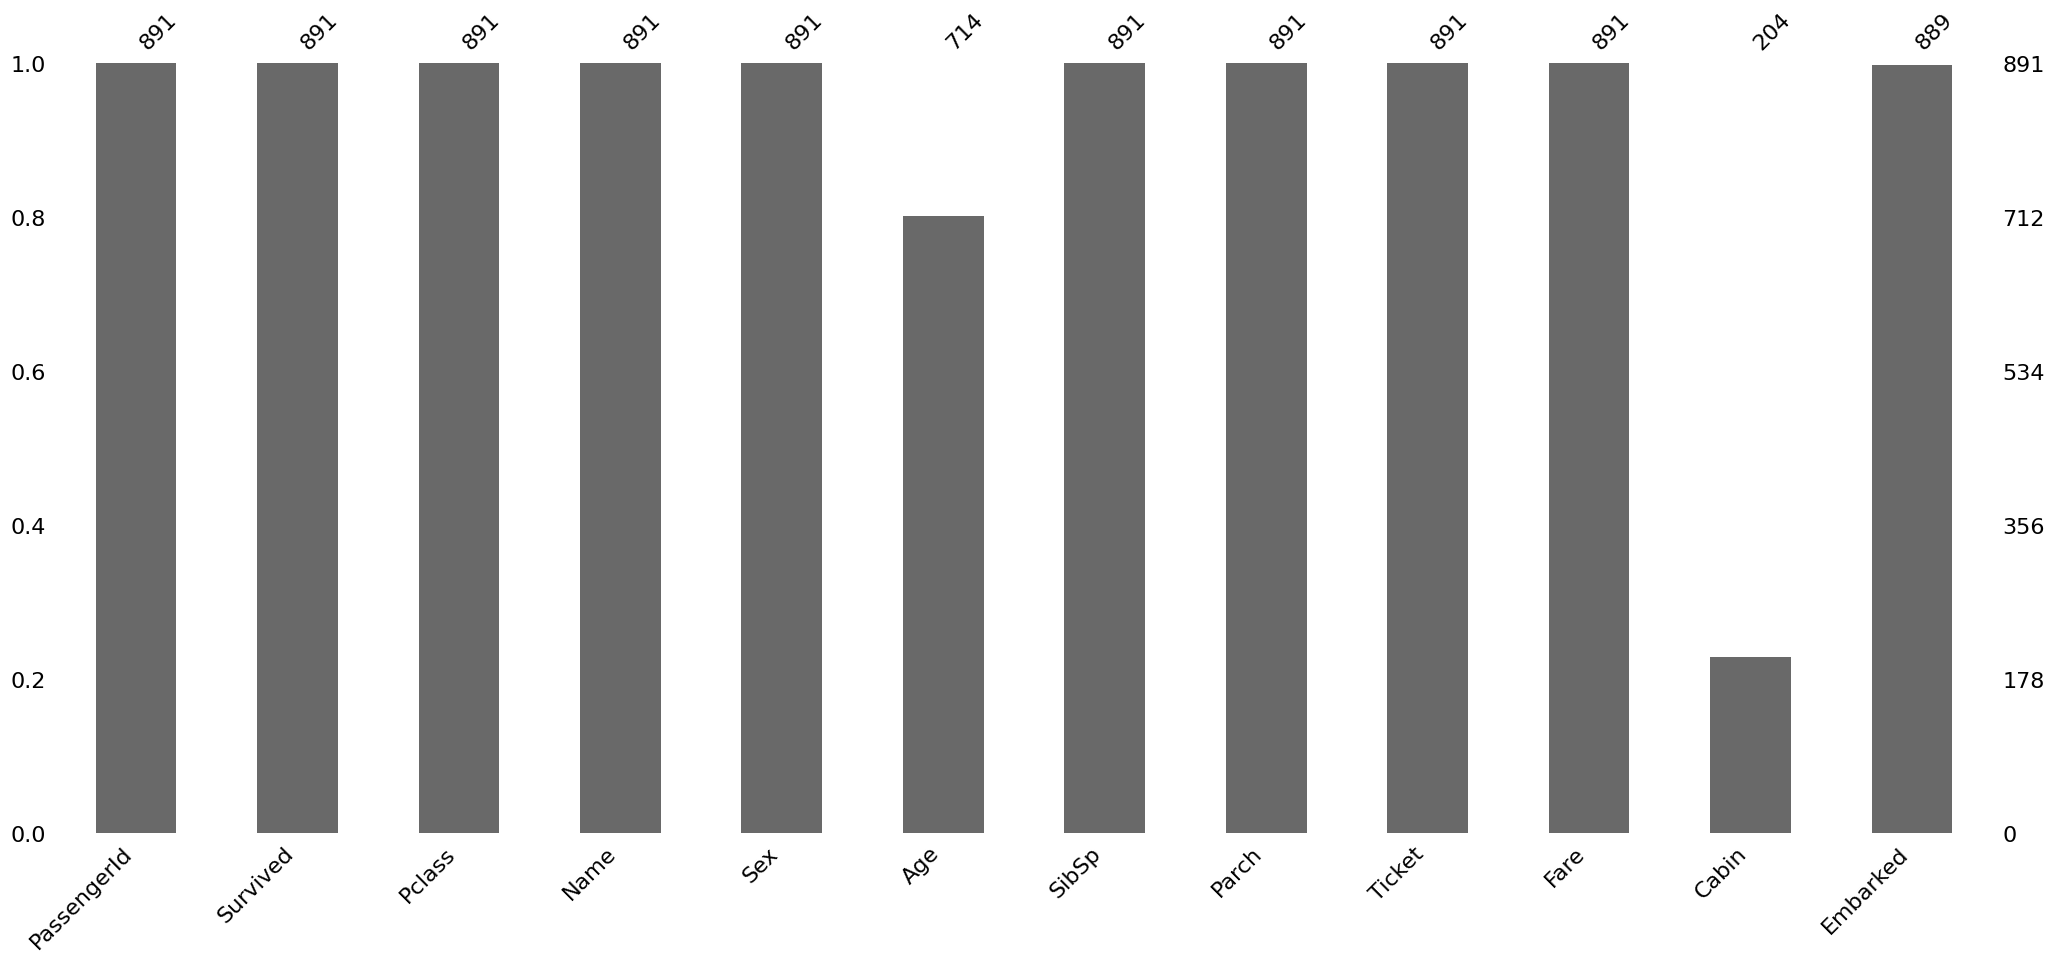

In [14]:
msno.bar(train)

>Гистограмма дает краткий графический обзор полноты набора данных. Мы видим, что в столбцах __Age__, __Cabin__ и __Embarked__ отсутствуют значения. Затем имело бы смысл выяснить, где находятся недостающие данные. Матрица `msno.matrix` представляет собой dense-матрицу, которая позволяет быстро визуально определять в каком месте пропущены значения (позволяет ответить на вопрос, есть ли закономерность в пропусках в зависимости от индекса наблюдения).

### Визуализация местоположения недостающих данных

>Матрица нулевых данных [msno.matrix](https://github.com/ResidentMario/missingno#matrix) - это отображение плотности данных, позволяющее быстро визуально выявить закономерности в заполнении данных.


Давайте рассмотрим, как интерпретировать диаграмму пропусков, созданную этой библиотекой:

1. **Белые полосы:** Каждая белая полоса на диаграмме представляет собой пропущенные значения в данных. Каждая горизонтальная полоса соответствует одной строке в вашем наборе данных. Если в строке присутствует хотя бы одно пропущенное значение, соответствующая полоса будет белой.

2. **Бар-графики:** Справа от белых полос на диаграмме пропусков находятся бар-графики, которые представляют процентное соотношение пропущенных значений в каждом столбце. Высота бара соответствует проценту отсутствующих данных в соответствующем столбце.

3. **Диагональные линии:** Если ваш набор данных отсортирован, диагональные линии на графике могут подчеркнуть структуру пропущенных значений, связанную с порядком строк в данных.


Анализируя диаграмму пропусков, вы можете определить, какие столбцы содержат больше пропущенных значений, и какие строки могут быть затронуты отсутствующими данными. Это может помочь в принятии решения относительно стратегии обработки пропущенных значений, таких как удаление строк или заполнение значений.

<Axes: >

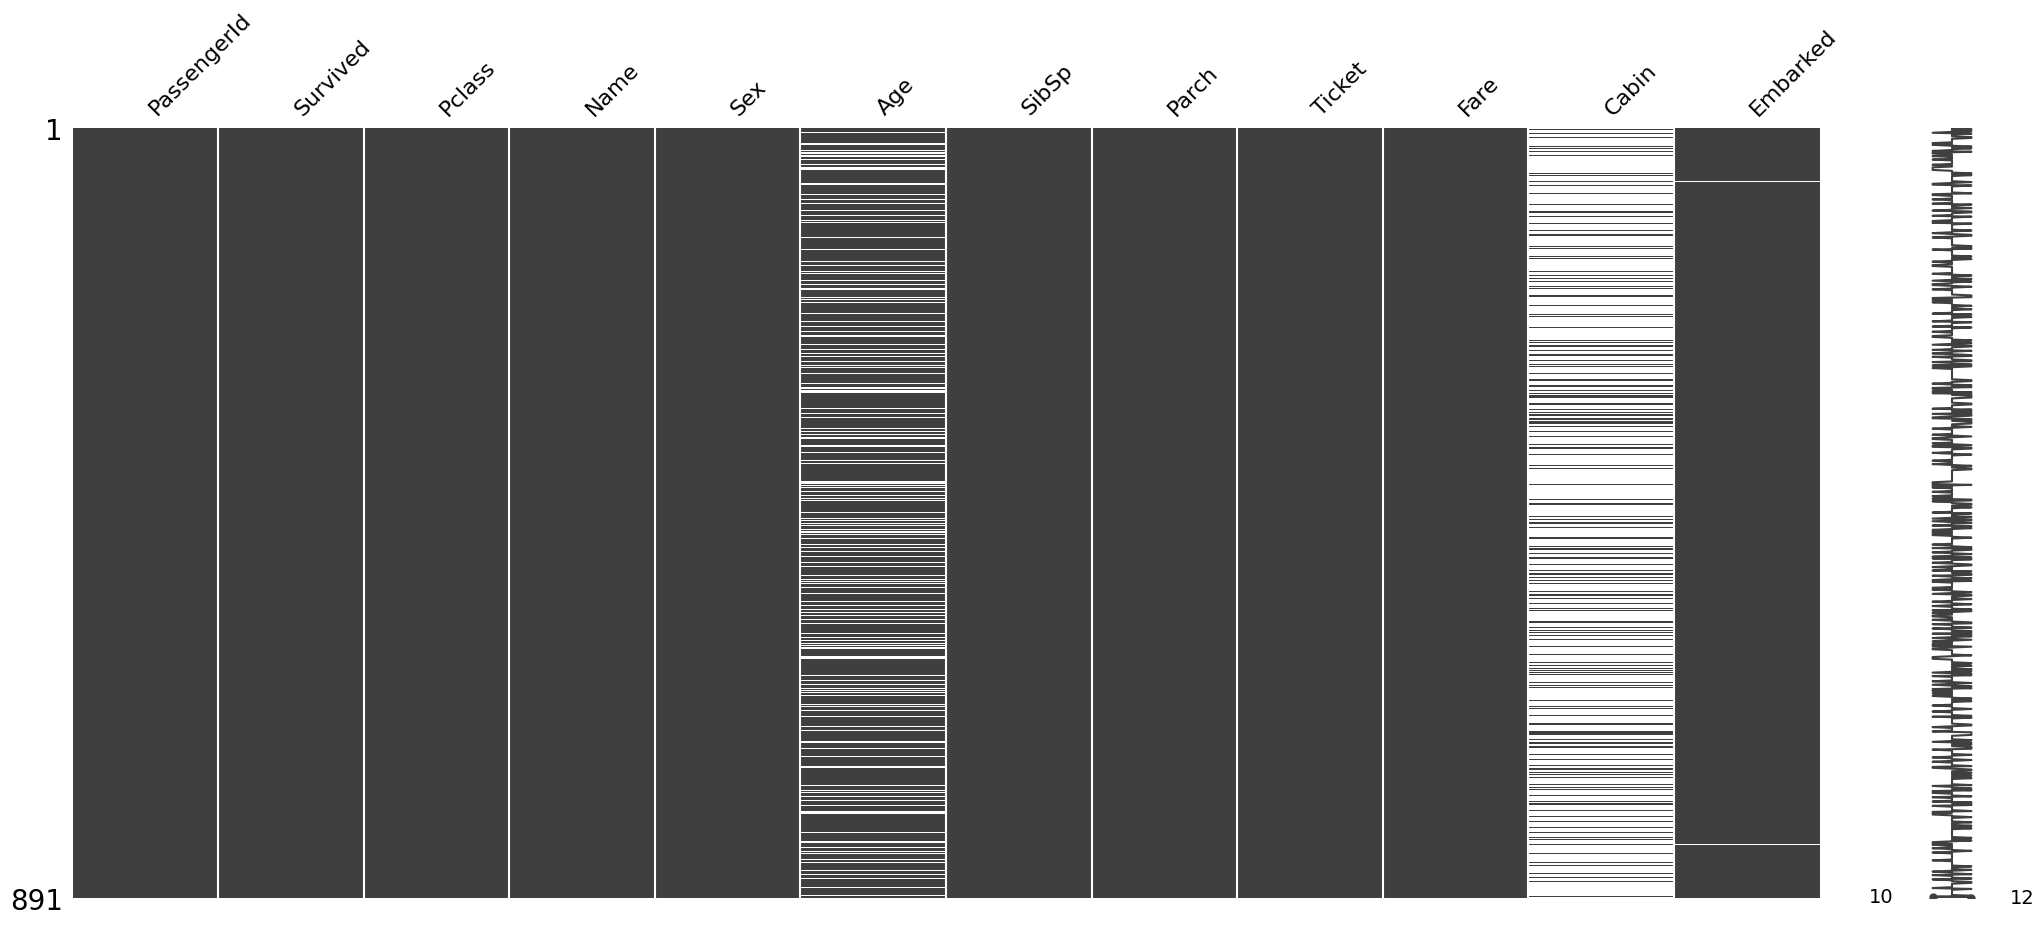

In [15]:
msno.matrix(train)

>* В столбце Embarked есть только два случая отсутствия данных, отсюда две белые линии.
>
>* Спарклайн справа дает представление об общей форме полноты данных и указывает количество столбцов без пропусков (10) и общее количество столбцов (12).
>

Также можно извлечь подвыборку из всего набора данных, чтобы определить точное местоположение пропущенных значений. Например, давайте проверим первые 100 строк.

<Axes: >

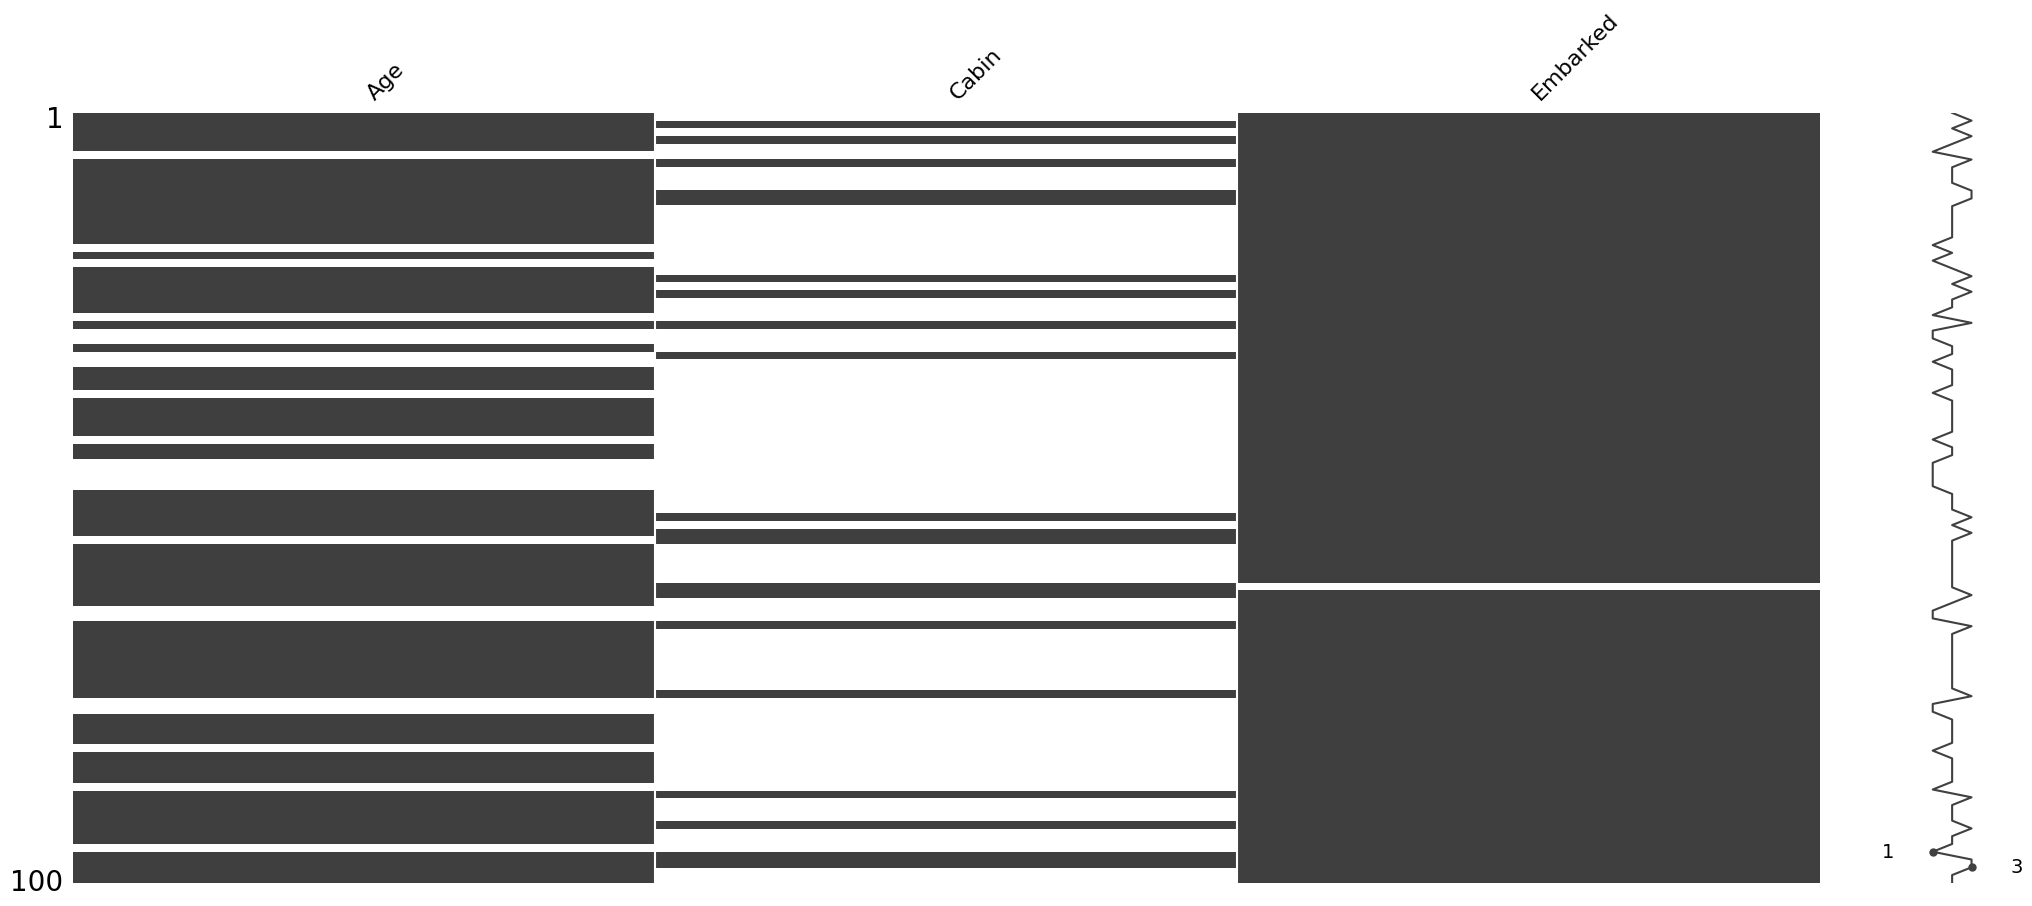

In [17]:
msno.matrix(train[['Age', 'Cabin', 'Embarked']].head(100))

Столбец Embarked имеет нулевое значение в первых 100 случаях.

## Причины отсутствующих значений

В 1976 году Дональд Рубин предложил классификацию пропущенных значений, которая включает три основных типа:

1. **MCAR (Missing Completely at Random) - Полностью случайные пропуски:**
   - Пропуски случайны и не зависят ни от значений других переменных, ни от самого пропущенного значения. В этом случае вероятность пропуска одинакова для всех наблюдений.
   
   Пропуски в этом случае случайным образом распределены по всему набору данных и не зависят от значений других переменных. Это может быть, например, результат случайной ошибки при вводе данных.

Пример:

Опрос проведен с использованием бумажных анкет, и пропуски возникли из-за случайного разлива кофе на нескольких анкетах во время транспортировки.

2. **MAR (Missing at Random) - Пропуски случайны:**
   - Вероятность пропуска зависит от значений других переменных в данных, но не от самого пропущенного значения. Это означает, что вероятность пропуска может быть объяснена другими переменными в наборе данных.
   
   В этом случае вероятность пропуска зависит от значений других переменных в данных. Например, отсутствие ответа может быть связано с каким-то общим фактором, но не напрямую с самим пропущенным значением.

Пример:

В опросе о доходах пропущенные значения могут быть зависимы от возраста респондента, но не от самого дохода.

3. **MNAR (Missing Not at Random) - Неслучайные пропуски:**
   - Вероятность пропуска зависит от самого пропущенного значения. Это может быть вызвано тем, что значения, которые не были введены, отличаются от тех, что были введены.
   
   В этом случае пропуски зависят от самого значения пропущенных данных, и это может привести к искаженным результатам. Такие пропуски могут возникнуть из-за того, что пропущенные значения связаны с тем, что исследуемые значения сами по себе не наблюдаемы.

Пример:

В исследовании по потреблению алкоголя люди с высоким уровнем потребления могут отказаться от дачи информации о своем фактическом потреблении, создавая тем самым пропуски, которые зависят от самого значения потребления.


Эта классификация является основополагающей в области обработки пропущенных данных и помогает понять характер пропусков, что в свою очередь влияет на выбор методов и стратегий их обработки. Но важно отметить, что в реальных данных тип пропусков может быть трудно однозначно определить. Анализ данных и внимательное изучение контекста могут помочь в принятии решения относительно стратегии обработки пропусков.

<AxesSubplot:>

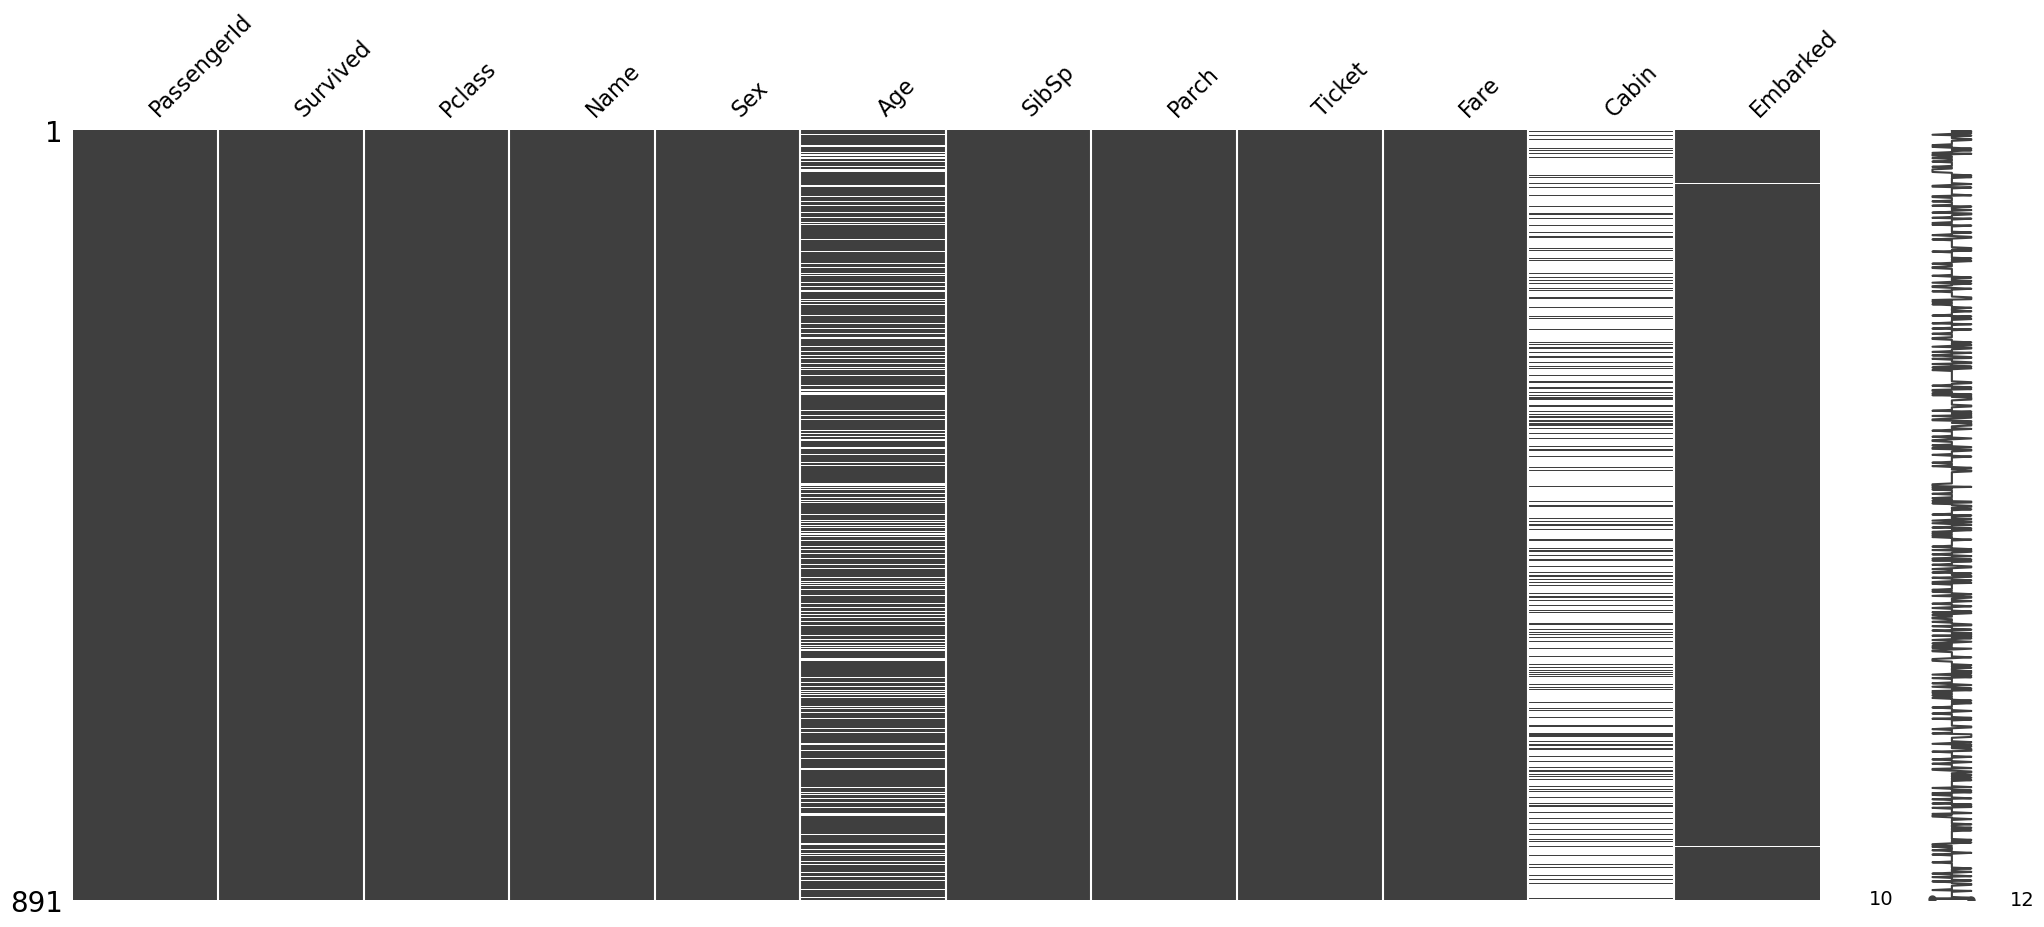

In [ ]:
msno.matrix(train)

* Столбец __Embarked__ имеет очень мало пропущенных значений, и, похоже, он не коррелирует с любым другим столбцом. Следовательно, пропуск в столбце __Embarked__ можно отнести к категории «Отсутствуют полностью случайно».


* И в столбцах __Age__, и в столбцах __Cabin__ много пропущенных значений. Это может быть случай MAR, поскольку мы не можем напрямую определить причину отсутствия данных в этих столбцах.

`missingno` также позволяет нам отсортировать график по определенному столбцу. Давайте отсортируем значения по столбцу __Age__ и __Cabin__, чтобы увидеть, есть ли закономерность в пропущенных значениях.


<AxesSubplot:>

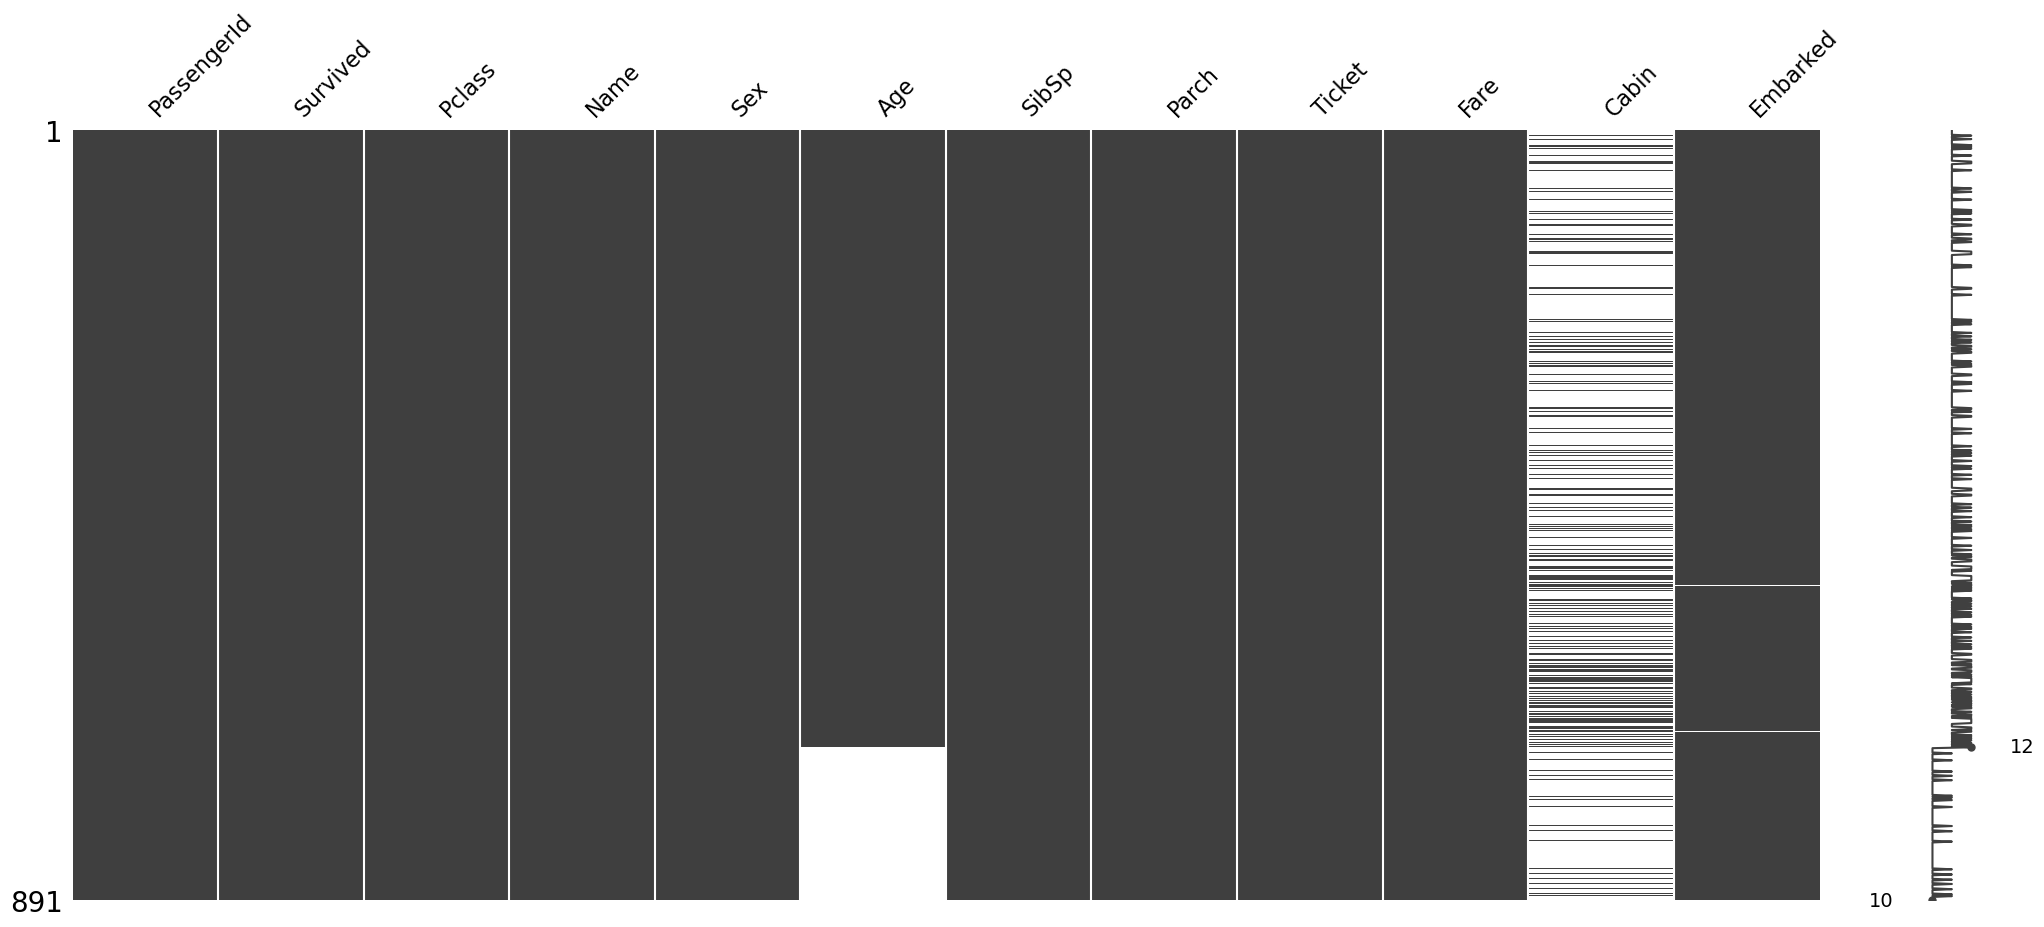

In [ ]:
sorted = train.sort_values('Age')
msno.matrix(sorted)

Отсюда ясно, что нет никакой связи между отсутствием в столбце __Age__ и __Cabin__. Чтобы дополнительно закрепить этот вывод, мы также можем визуализировать тепловую карту для разного набора признаков.

<Axes: >

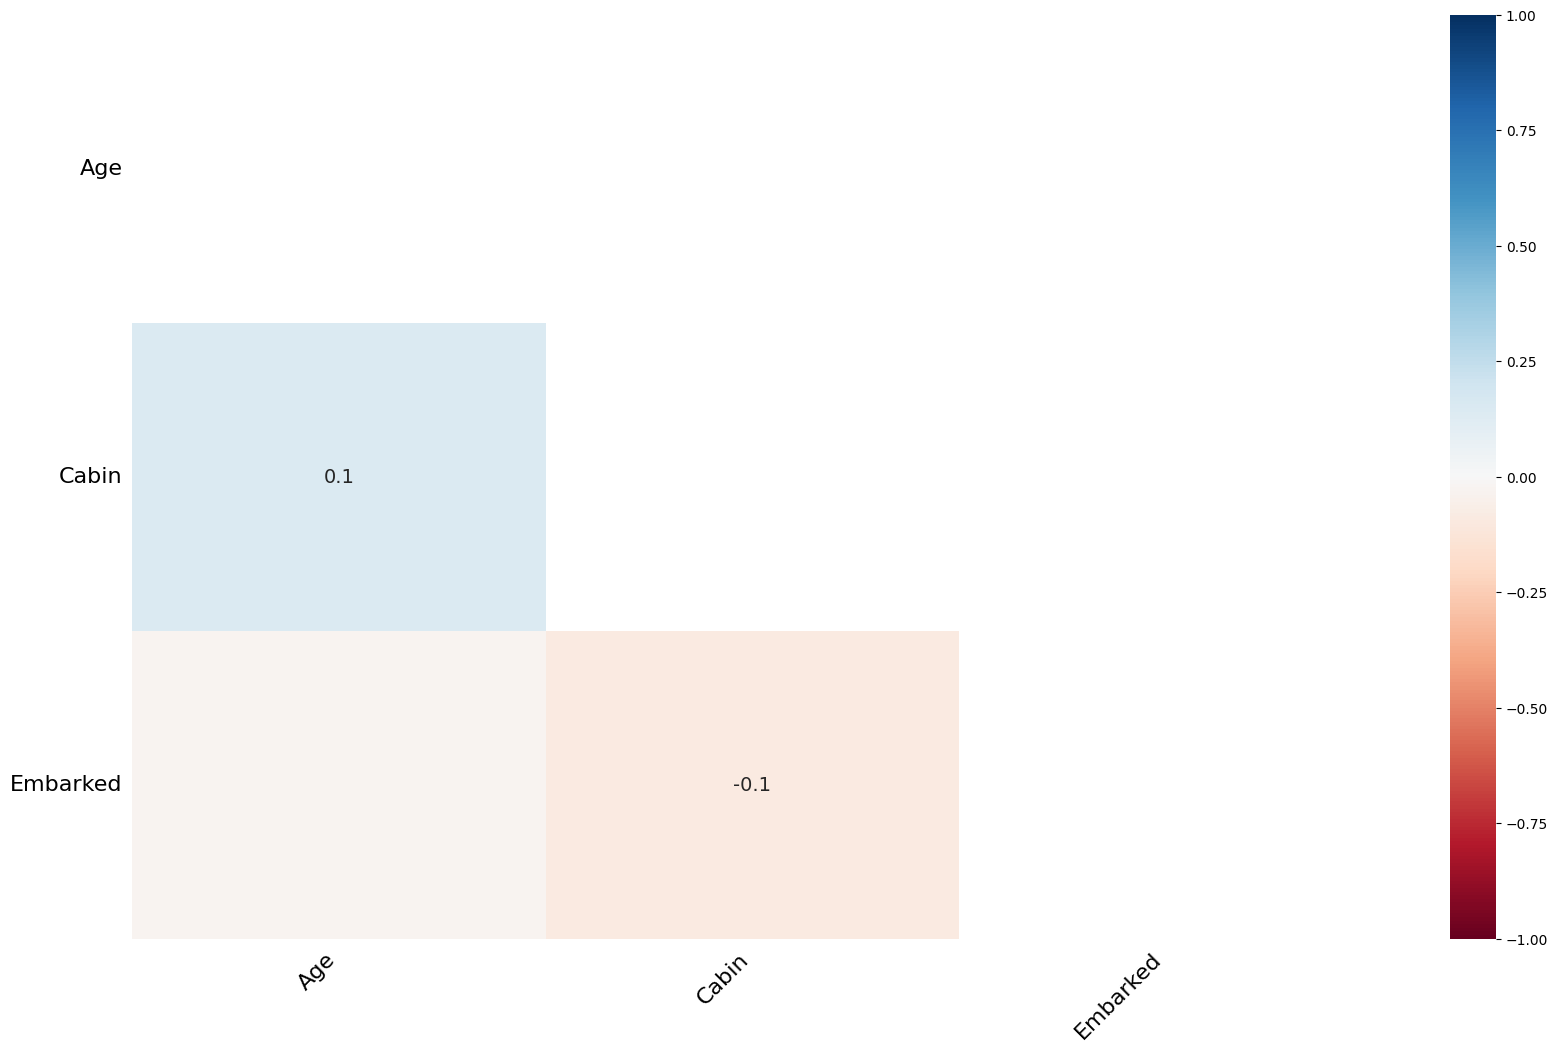

In [18]:
msno.heatmap(train)

Тепловая карта показывает, что нет сильной корреляции между пропусками в разных признаках. Это хорошо; низкие корреляции указывают на то, что пропуски относятся к __MAR__.

## Поиск причины отсутствия данных с помощью дендограммы

Дендограмма - это древовидная диаграмма. Он объединяет сильно коррелированные переменные.

Дендрограмма пропусков в библиотеке `missingno` используется для визуализации структуры пропусков в данных. Эта дендрограмма представляет собой древовидную структуру, которая позволяет оценить взаимосвязи между пропущенными значениями в различных переменных.


1. **Древовидная структура:**
   - Вертикальные и горизонтальные линии на дендрограмме представляют переменные с пропущенными значениями.
   - Дендрограмма группирует переменные в зависимости от схожести их пропущенных значений.

2. **Высота ветвей:**
   - Высота каждой ветви отражает степень схожести пропущенных значений между соответствующими переменными.
   - Более высокие ветви группируют переменные с более схожими пропусками.

3. **Кластеризация переменных:**
   - Переменные, расположенные близко друг к другу в дендрограмме, могут быть сгруппированы в кластеры, что указывает на схожесть структуры пропусков.

Интерпретация дендрограммы может помочь в понимании, какие переменные взаимосвязаны в отношении пропущенных значений. Это может быть полезным для выбора стратегии обработки пропусков и лучшего понимания структуры данных.



<Axes: >

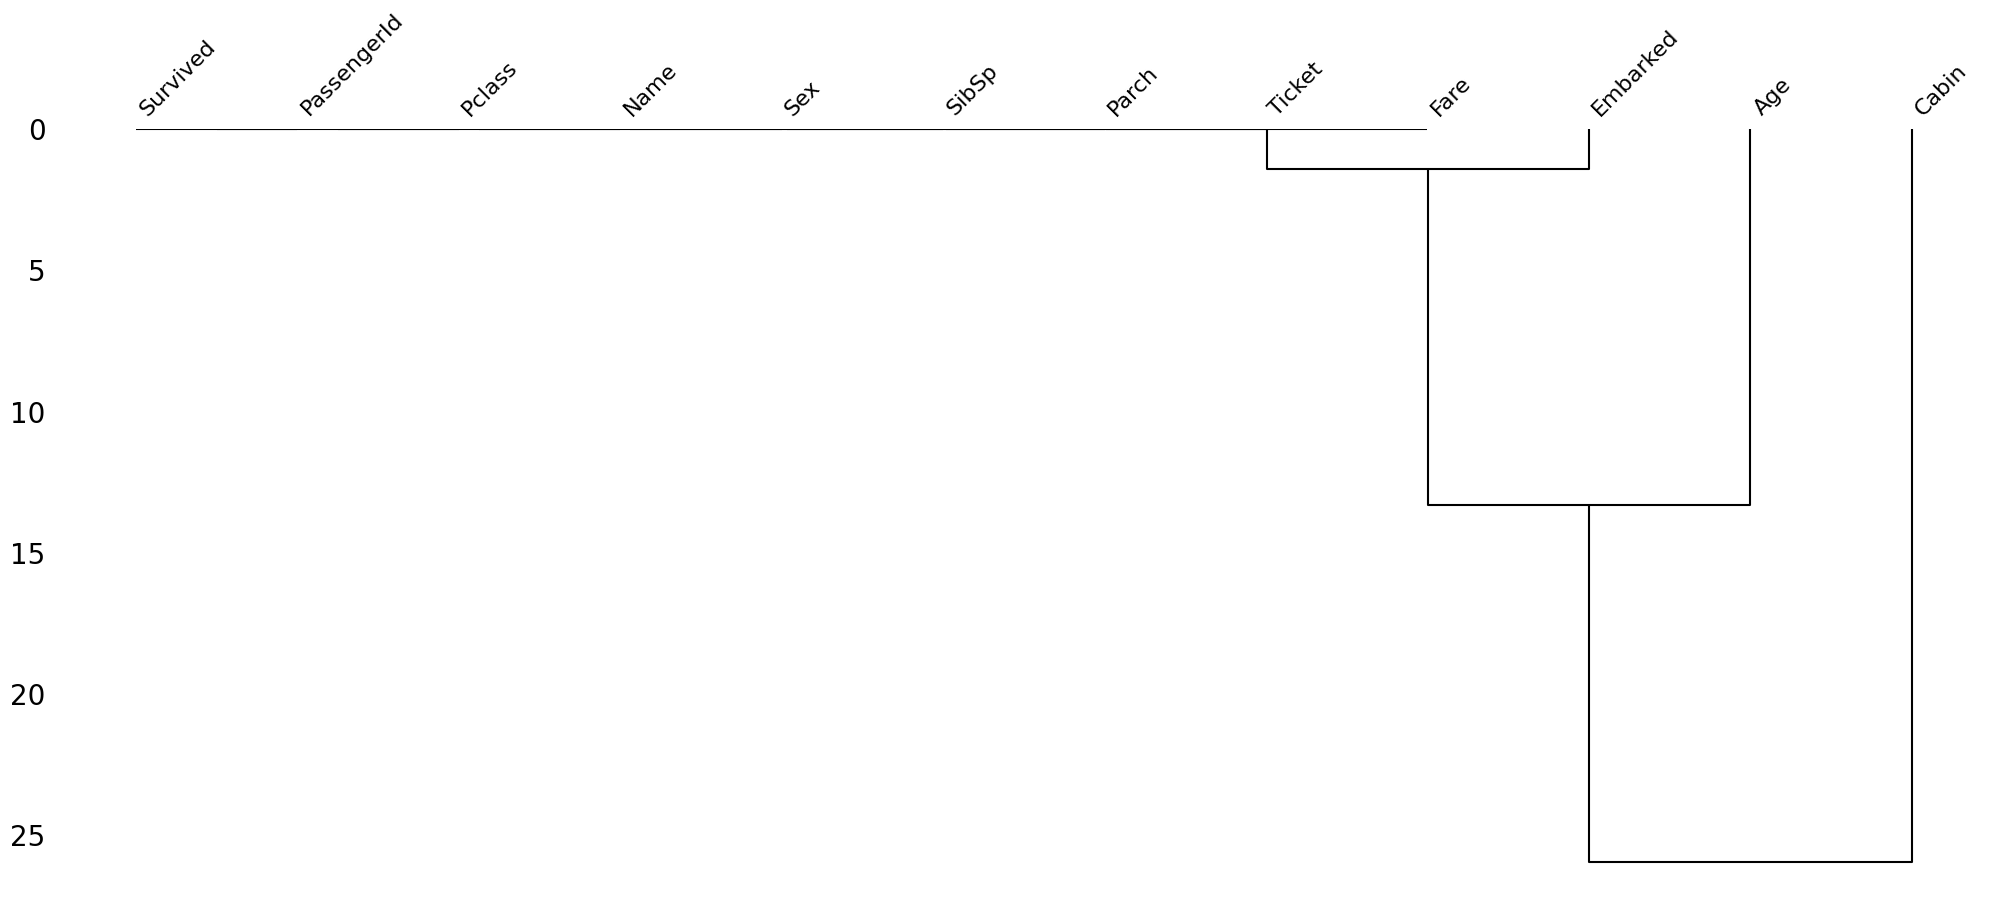

In [19]:
msno.dendrogram(train)

Давайте прочитаем приведенную выше дендрограмму сверху вниз:

* Листья, которые связаны между собой на нулевой отметке, полностью предсказывают присутствие друг друга - одна переменная всегда может быть пустой, когда другая заполнена, или они всегда могут быть заполнены обе или обе пустыми.


>![Screenshot%202020-04-25%20at%208.19.56%20AM.png](attachment:Screenshot%202020-04-25%20at%208.19.56%20AM.png)
>
>* Пропуски в __Embarked__ обычно больше похоже на __Age__, чем на __Fare__ / __Ticket__. Однако в этом конкретном случае корреляция высока, поскольку в столбце __Embarked__ очень мало пропущенных значений.

В этом наборе данных не так много пропущенных значений, но если использовать ту же методику для наборов данных с большим количеством пропущенных значений, то обязательно возникнет интересная закономерность.

Анализ дендрограммы пропусков может предоставить информацию о структуре пропущенных значений в данных и помочь в выборе стратегии их обработки. Вот несколько стратегий, которые могут быть рассмотрены после анализа дендрограммы:

1. **Группировка переменных:**
   - Если на дендрограмме видны четкие группы переменных с схожими пропусками, можно рассмотреть группировку этих переменных вместе. Это может быть полезно при заполнении пропусков, поскольку значения в одной группе могут быть заполнены на основе значений в другой.

2. **Использование информации о схожести:**
   - Поскольку высота ветвей на дендрограмме отражает степень схожести пропусков, можно использовать эту информацию для определения, какие переменные ближе по структуре пропусков. Это может влиять на выбор метода заполнения пропусков.

3. **Стратификация данных:**
   - Разделяйте данные на подгруппы в соответствии с группировкой переменных, выявленной на дендрограмме. Затем применяйте различные стратегии заполнения пропусков для каждой подгруппы.

4. **Уточнение методов заполнения:**
   - Если дендрограмма указывает на явные кластеры переменных с схожими пропусками, можно использовать более сложные методы заполнения, такие как многомерная интерполяция, чтобы учесть структуру данных более точно.

5. **Удаление переменных или строк:**
   - В случае, если дендрограмма показывает, что некоторые переменные или строки полностью отсутствуют (образуют кластер), рассмотрите возможность удаления этих переменных или строк, если они несущественны для анализа.


## Обработка отсутствующих значений

После выявления закономерностей в пропущенных значенияхб можно присутпать к их обработке.


## Удаление

![](https://imgur.com/tBvdfyX.png)

>__Удаление__ означает удаление недостающих значений из набора данных. Однако это не рекомендуется, так как это может привести к потере информации из набора данных. Мы должны удалять отсутствующие значения из набора данных только в том случае, если их доля очень мала. Кроме того, удаления бывают трех типов:
>


Существует несколько типов удаления пропусков, и выбор конкретного типа зависит от контекста данных и задачи анализа. Вот основные типы удаления пропусков:

1. **Удаление полных строк (удаление по строкам):**
   - Удаляются все строки, в которых есть хотя бы одно пропущенное значение. Этот метод используется, когда небольшое количество строк содержит пропущенные значения и сохранение этих строк не представляет большой ценности для анализа.

2. **Удаление полных столбцов (удаление по столбцам):**
   - Удаляются все столбцы, в которых есть хотя бы одно пропущенное значение. Этот метод используется, когда большое количество столбцов содержит пропущенные значения и сохранение этих столбцов не представляет ценности для анализа.

3. **Удаление по условию (по определенному условию):**
   - Удаляются только те строки или столбцы, в которых пропущенные значения соответствуют определенному условию. Например, можно удалять строки, в которых пропущены значения в ключевых переменных.

Выбор типа удаления зависит от конкретной ситуации и задачи:

- **Удаление строк:** Применяется, когда пропущенные значения в данных несущественны для анализа, и удалять строки с пропусками не влияет на общие выводы.

- **Удаление столбцов:** Используется, если конкретные переменные (столбцы) с пропусками не являются ключевыми для анализа и несущественны для целей моделирования.

- **Удаление по условию:** Применяется, когда пропуски в данных имеют особое значение, например, если пропуски связаны с ключевыми переменными, и удаление таких наблюдений ухудшит анализ.

Необходимость удаления пропусков должна оцениваться в контексте конкретной задачи и учитывать возможные последствия для общего анализа и моделирования данных.


### Парное удаление

Парное удаление используется, когда значения отсутствуют полностью случайным образом. При попарном удалении удаляются только недостающие значения. Можно корректно применять для `MCAR`.


In [20]:
train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [22]:
train_1 = train.copy()
train_1['Age'].mean() # pandas пропускает отсутствующие значения и вычисляет среднее оставшихся значений.

np.float64(29.69911764705882)


### Списочное удаление / удаление строк

>Во время удаления по списку удаляются полные строки, содержащие отсутствующие значения. В результате, такой подход также называется полным удалением. Как и попарное удаление, удаление по списку также используется только для значений `MCAR`.


In [23]:
# Убираем строки, содержащие NaN или отсутствующее значение для столбца Age
train_1.dropna(subset=['Age'],how='any',inplace=True)
train_1['Age'].isnull().sum()

np.int64(0)

In [24]:
train_1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


>В столбце __Age__ нет пропущенных значений. Основным недостатком удаления по списку является то, что большая часть данных и, следовательно, большая часть информации теряется. Рекомендуется использовать его только тогда, когда количество пропущенных значений очень мало.


### Удаление полных столбцов

Если в столбце много пропущенных значений, скажем, более 90%, и признак не значимый, можно целиком удалить этот признак. Однако, опять же, это не лучшая методика удаления данных.


## Заполнение пропусков


![](https://imgur.com/bL0iHde.png)

>Существует множество способов вменения недостающих значений в зависимости от характера проблемы и данных. В зависимости от характера проблемы методы вменения могут быть классифицированы следующим образом:

### Базовые способы замены пропусков


1. **Заполнение средним (mean imputation):** Пропущенные значения заполняются средним значением по столбцу. Этот метод хорош для **числовых данных**, не имеющих слишком больших выбросов.

2. **Заполнение медианой (median imputation):** Пропущенные значения заменяются медианным значением по столбцу. Этот метод более **устойчив к выбросам**, чем использование среднего.

3. **Заполнение модой (mode imputation):** Для категориальных данных можно использовать **моду** (наиболее часто встречающееся значение) для заполнения пропусков.

Для таких способов замены пропусков можно использовать класс `SimpleImputer` из `sklearn`



In [ ]:
# !pip install scikit-learn==1.4.0

In [25]:
# заполнение константой

from sklearn.impute import SimpleImputer
train_constant = train.copy()
# устанавливаем стратегию 'constant'
mean_imputer = SimpleImputer(strategy='constant') # imputing using constant value
train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)
train_constant.isnull().sum()

/tmp/ipython-input-3982362900.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[22.0, 38.0, 26.0, 35.0, 35.0, 'missing_value', 54.0, 2.0, 27.0, 14.0, 4.0, 58.0, 20.0, 39.0, 14.0, 55.0, 2.0, 'missing_value', 31.0, 'missing_value', 35.0, 34.0, 15.0, 28.0, 8.0, 38.0, 'missing_value', 19.0, 'missing_value', 'missing_value', 40.0, 'missing_value', 'missing_value', 66.0, 28.0, 42.0, 'missing_value', 21.0, 18.0, 14.0, 40.0, 27.0, 'missing_value', 3.0, 19.0, 'missing_value', 'missing_value', 'missing_value', 'missing_value', 18.0, 7.0, 21.0, 49.0, 29.0, 65.0, 'missing_value', 21.0, 28.5, 5.0, 11.0, 22.0, 38.0, 45.0, 4.0, 'missing_value', 'missing_value', 29.0, 19.0, 17.0, 26.0, 32.0, 16.0, 21.0, 26.0, 32.0, 25.0, 'missing_value', 'missing_value', 0.83, 30.0, 22.0, 29.0, 'missing_value', 28.0, 17.0, 33.0, 16.0, 'missing_value', 23.0, 24.0, 29.0, 20.0, 46.0, 26.0, 59.0, 'missing_value', 71.0, 23.0, 34.0, 34.0, 28.0, 'miss

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [26]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [27]:
train_constant

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,missing_value,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,missing_value,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,missing_value,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,missing_value,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,missing_value,1,2,W./C. 6607,23.4500,missing_value,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [28]:
train_constant[train_constant['Age']=='missing_value']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,missing_value,0,0,330877,8.4583,missing_value,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,missing_value,0,0,244373,13.0000,missing_value,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,missing_value,0,0,2649,7.2250,missing_value,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,missing_value,0,0,2631,7.2250,missing_value,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,missing_value,0,0,330959,7.8792,missing_value,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,missing_value,0,0,2629,7.2292,missing_value,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,missing_value,8,2,CA. 2343,69.5500,missing_value,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,missing_value,0,0,345777,9.5000,missing_value,S
878,879,0,3,"Laleff, Mr. Kristo",male,missing_value,0,0,349217,7.8958,missing_value,S


In [29]:
from sklearn.impute import SimpleImputer
train_most_frequent = train.copy()
# устанавливаем стратегию 'mean'
mean_imputer = SimpleImputer(strategy='most_frequent') # стратегия также может быть mean или median
train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)

In [30]:
train_most_frequent.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [38]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [37]:
train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


In [34]:
train.Cabin.value_counts()

,count
Cabin,
G6,4
C23 C25 C27,4
B96 B98,4
F2,3
D,3
...,...
E17,1
A24,1
C50,1


## Методы заполнения пропусков на основе ML

В более продвинутых методах заполнения пропусков используются алгоритмы машинного обучения. В отличие от предыдущих методов, в которых мы использовали другие значения столбцов для прогнозирования пропущенных значений. В этом разделе мы рассмотрим следующие две техники:

* [Nearest neighbors imputation](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)
* [Multivariate feature imputation](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)

### Замена пропусков с помощью KNN

Класс `KNNImputer` обеспечивает заполнение пропущенных значений с использованием метода k-ближайших соседей. Каждый отсутствующий признак заполняется с использованием значений из `n_neighbors` ближайших соседей, которые имеют значение для этого признака. Характеристики соседей усредняются равномерно или взвешиваются по расстоянию до каждого соседа.

In [48]:
train_knn = train.copy(deep=True)
test_knn = test.copy(deep=True)

In [40]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=3)
train_knn['Age'] = knn_imputer.fit_transform(train_knn[['Age']])

In [41]:
train_knn['Age'].isnull().sum()


np.int64(0)

In [43]:
train['Age']

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
...,...
886,27.0
887,19.0
888,NaN
889,26.0


In [42]:
train_knn['Age']

,Age
0,22.000000
1,38.000000
2,26.000000
3,35.000000
4,35.000000
...,...
886,27.000000
887,19.000000
888,29.699118
889,26.000000


In [44]:
test_knn['Age']

,Age
0,34.5
1,47.0
2,62.0
3,27.0
4,22.0
...,...
413,NaN
414,39.0
415,38.5
416,NaN


In [45]:
test_knn['Age'] = knn_imputer.transform(test_knn[['Age']])

In [46]:
test_knn['Age']

,Age
0,34.500000
1,47.000000
2,62.000000
3,27.000000
4,22.000000
...,...
413,29.699118
414,39.000000
415,38.500000
416,29.699118


In [49]:
train_knn = train_knn[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
train_knn

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500
...,...,...,...,...,...
886,2,27.0,0,0,13.0000
887,1,19.0,0,0,30.0000
888,3,NaN,1,2,23.4500
889,1,26.0,0,0,30.0000


In [50]:
knn_imputer = KNNImputer(n_neighbors=3)
knn_imputer.fit_transform(train_knn)

array([[ 3.        , 22.        ,  1.        ,  0.        ,  7.25      ],
       [ 1.        , 38.        ,  1.        ,  0.        , 71.2833    ],
       [ 3.        , 26.        ,  0.        ,  0.        ,  7.925     ],
       ...,
       [ 3.        , 25.33333333,  1.        ,  2.        , 23.45      ],
       [ 1.        , 26.        ,  0.        ,  0.        , 30.        ],
       [ 3.        , 32.        ,  0.        ,  0.        ,  7.75      ]])

In [51]:
test_knn = test_knn[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
test_knn

,Pclass,Age,SibSp,Parch,Fare
0,3,34.5,0,0,7.8292
1,3,47.0,1,0,7.0000
2,2,62.0,0,0,9.6875
3,3,27.0,0,0,8.6625
4,3,22.0,1,1,12.2875
...,...,...,...,...,...
413,3,NaN,0,0,8.0500
414,1,39.0,0,0,108.9000
415,3,38.5,0,0,7.2500
416,3,NaN,0,0,8.0500


In [52]:
knn_imputer.transform(test_knn)

array([[ 3.    , 34.5   ,  0.    ,  0.    ,  7.8292],
       [ 3.    , 47.    ,  1.    ,  0.    ,  7.    ],
       [ 2.    , 62.    ,  0.    ,  0.    ,  9.6875],
       ...,
       [ 3.    , 38.5   ,  0.    ,  0.    ,  7.25  ],
       [ 3.    , 31.5   ,  0.    ,  0.    ,  8.05  ],
       [ 3.    , 12.    ,  1.    ,  1.    , 22.3583]])

https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Многомерная импутация пропусков посредством связанных уравнений (MICE)

Стратегия заполнения пропущенных значений путем моделирования каждого признака с пропущенными значениями в зависимости от других функций в циклическом стиле. Этот подход использует несколько множественный регрессий по случайной выборке данных, затем берет среднее из значений множественной регрессии и использует это значение для заполнения пропущенного значения. В `sklearn` это реализовано следующим образом:

In [65]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
train_mice = train.copy(deep=True)

In [62]:
mice_imputer = IterativeImputer(random_state=45)

In [63]:
mice_imputer.random_state

45

In [67]:
mice_imputer.fit_transform(train_mice[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])

array([[ 3.        , 22.        ,  1.        ,  0.        ,  7.25      ],
       [ 1.        , 38.        ,  1.        ,  0.        , 71.2833    ],
       [ 3.        , 26.        ,  0.        ,  0.        ,  7.925     ],
       ...,
       [ 3.        , 21.13265306,  1.        ,  2.        , 23.45      ],
       [ 1.        , 26.        ,  0.        ,  0.        , 30.        ],
       [ 3.        , 32.        ,  0.        ,  0.        ,  7.75      ]])

In [68]:
test_mice = test.copy(deep=True)

In [69]:
mice_imputer.transform(test_mice[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])

array([[ 3.        , 34.5       ,  0.        ,  0.        ,  7.8292    ],
       [ 3.        , 47.        ,  1.        ,  0.        ,  7.        ],
       [ 2.        , 62.        ,  0.        ,  0.        ,  9.6875    ],
       ...,
       [ 3.        , 38.5       ,  0.        ,  0.        ,  7.25      ],
       [ 3.        , 27.6245438 ,  0.        ,  0.        ,  8.05      ],
       [ 3.        , 22.36921183,  1.        ,  1.        , 22.3583    ]])

In [57]:
train_mice['Age'].isnull().sum()

np.int64(0)

In [58]:
train_mice['Age']

,Age
0,22.000000
1,38.000000
2,26.000000
3,35.000000
4,35.000000
...,...
886,27.000000
887,19.000000
888,29.699118
889,26.000000


In [59]:
test_knn['Age'] = mice_imputer.transform(test_knn[['Age']])

In [60]:
test_knn['Age']

,Age
0,34.500000
1,47.000000
2,62.000000
3,27.000000
4,22.000000
...,...
413,29.699118
414,39.000000
415,38.500000
416,29.699118


# Алгоритмы, которые умеют в обработку пропусков

Некоторые алгоритмы, такие как `XGBoost`, `LightGBM`, `CatBoost` могут обрабатывать отсутствующие значения без какой-либо предварительной обработки, предоставляя соответствующие параметры.


* [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
![](https://imgur.com/GNlcWoJ.png)


* [LightGBm](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html)
![](https://imgur.com/GVdcx7h.png)



### Способы замены пропусков в задаче с временной зависимостью

Теперь давайте рассмотрим способы замены пропущенных значений в типичной задаче временных рядов. Решение проблемы пропущенных значений в задаче с временной зависимостью немного отличается. Метод `fillna()` используется для подстановки пропущенных значений в таких задачах. Основные методы замены пропусков:

* `ffill` или `pad` - заменить `NaN` последним наблюдаемым значением


* `bfill` или `backfill` - заменить `NaN` следующим наблюдаемым значением


* Метод линейной интерполяции



In [ ]:
city_day = pd.read_csv(
    "./data/city_day.csv", parse_dates=True,index_col='Date')
city_day1=city_day.copy(deep=True)
city_day.head(n=2)

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Ahmedabad,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
2015-01-02,Ahmedabad,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN


In [ ]:
data_missing = missing_values_table(city_day)
data_missing

В датасете 15 колонок.
В 14 колнках есть пропущенные значения.


,Пропущенных значений,% от общего количества
Xylene,18109,61.3
PM10,11140,37.7
NH3,10328,35.0
Toluene,8041,27.2
Benzene,5623,19.0
AQI,4681,15.9
AQI_Bucket,4681,15.9
PM2.5,4598,15.6
NOx,4185,14.2
O3,4022,13.6


Имеется много пропущенных значений, а в некоторых столбцах, таких как __Xylene__, а в __PM10__ более 50% значений. Давайте теперь посмотрим, как мы можем заменить эти недостающие значения.

In [ ]:
city_day['Xylene'][50:64]

Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26      NaN
2015-02-27      NaN
2015-02-28      NaN
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
Name: Xylene, dtype: float64

Выше мы видим, что в столбце __Xylene__ отсутствуют 3 значения.

#### ffill

In [ ]:
city_day.fillna(method='ffill',inplace=True)
city_day['Xylene'][50:65]

Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26     0.81
2015-02-27     0.81
2015-02-28     0.81
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
2015-03-06     4.13
Name: Xylene, dtype: float64

#### bfill

In [ ]:
city_day['AQI'][20:30]

Date
2015-01-21      NaN
2015-01-22      NaN
2015-01-23      NaN
2015-01-24      NaN
2015-01-25      NaN
2015-01-26      NaN
2015-01-27      NaN
2015-01-28      NaN
2015-01-29    209.0
2015-01-30    328.0
Name: AQI, dtype: float64

In [ ]:
city_day.fillna(method='bfill',inplace=True)
city_day['AQI'][20:30]

Date
2015-01-21    209.0
2015-01-22    209.0
2015-01-23    209.0
2015-01-24    209.0
2015-01-25    209.0
2015-01-26    209.0
2015-01-27    209.0
2015-01-28    209.0
2015-01-29    209.0
2015-01-30    328.0
Name: AQI, dtype: float64

## Линейная интерполяция

Временные ряды могут сильно изменяться во времени. Следовательно, вместо использования `ffill` и `bfill` - не самое лучшее решение проблемы пропущенного значения. Более подходящей альтернативой было бы использование методов интерполяции, при которых значения заполняются увеличивающимися или уменьшающимися значениями.

__Линейная интерполяция__ - это метод заполнения пропусков, который предполагает линейную взаимосвязь между наблюдениями и использует непропущенные значения из соседних наблюдений для вычисления значения для отсутствующих наблюдений. Существует большое количество стратегий использования интерполяции. Описание тут: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html

In [ ]:
city_day1['Xylene'][50:65]

Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26      NaN
2015-02-27      NaN
2015-02-28      NaN
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
2015-03-06      NaN
Name: Xylene, dtype: float64

In [ ]:
city_day1.interpolate(limit_direction="both",inplace=True)
city_day1['Xylene'][50:65]

Date
2015-02-20     7.4800
2015-02-21    15.4400
2015-02-22     8.4700
2015-02-23    28.4600
2015-02-24     6.0500
2015-02-25     0.8100
2015-02-26     0.9375
2015-02-27     1.0650
2015-02-28     1.1925
2015-03-01     1.3200
2015-03-02     0.2200
2015-03-03     2.2500
2015-03-04     1.5500
2015-03-05     4.1300
2015-03-06     2.2600
Name: Xylene, dtype: float64

**EM-алгоритм (Expectation-Maximization):** Это статистический метод, который итеративно оценивает параметры распределения данных с учетом пропущенных значений.

Выбор метода зависит от конкретной ситуации, типа данных и природы пропусков. Важно также учитывать возможные искажения, которые могут появиться в результате выбора конкретного метода. Всегда рекомендуется внимательно изучать данные и проводить анализ влияния выбранного метода на конечные результаты модели.

## Ссылки

* [Dealing with Missing Data in Python](https://campus.datacamp.com/courses/dealing-with-missing-data-in-python/the-problem-with-missing-data?ex=1)
* [How to Handle Missing Data](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4)

https://www.dmitrymakarov.ru/data-analysis/nan-06/